In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import numpy as np
from vector_quantize_pytorch import ResidualVQ

from typing import Union, List, Tuple
from collections import defaultdict

In [2]:
class CausalConv1d(nn.Conv1d):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.causal_padding = self.dilation[0] * (self.kernel_size[0]-1)
        
    def forward(self, x):
        px = F.pad(x, [self.causal_padding, 0])
        return self._conv_forward(px, self.weight, self.bias)

# derived from https://github.com/wesbz/SoundStream/blob/main/net.py
class CausalConvTranspose1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, **kwargs):
        
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.causal_padding = kernel_size - 1
        
        self.conv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, **kwargs)

    def forward(self, x):
        n = x.shape[-1]
        out = self.conv(x)
        out = out[..., :(n * self.stride)] # remove padding from right

        return out

In [3]:
class SSResidualUnit(nn.Module):
    
    def __init__(self, channels:int, dilation:int):
        
        super(SSResidualUnit, self).__init__()
        
        self.channels = channels
        self.dilation = dilation
        
        self.sequence = nn.Sequential(
            CausalConv1d(in_channels=channels, out_channels=channels, kernel_size=7, dilation=dilation),
            nn.ELU(),
            nn.Conv1d(channels, channels, kernel_size=1)
        )
        
    def forward(self, x):
        h = self.sequence(x)
        return x + h
    
s = SSResidualUnit(2, 7)
x = torch.randn((1, 2, 64))
s.sequence[0](x).shape

torch.Size([1, 2, 64])

In [4]:
class SSEncoderBlock(nn.Module):
    
    def __init__(self, channels:int, stride:int):
        
        super(SSEncoderBlock, self).__init__()
        
        self.channels = channels
        self.stride = stride
        
        self.resid_0 = SSResidualUnit(self.channels // 2, dilation = 1)
        self.resid_1 = SSResidualUnit(self.channels // 2, dilation = 3)
        self.resid_2 = SSResidualUnit(self.channels // 2, dilation = 9)
        self.activation = nn.ELU()
        
        self.out_conv = CausalConv1d(in_channels=self.channels // 2, out_channels=self.channels, kernel_size=2*self.stride, stride=self.stride)
        
    def forward(self, x):
        x0 = self.activation(self.resid_0(x))
        x1 = self.activation(self.resid_0(x0))
        x2 = self.activation(self.resid_0(x1))
        out = self.out_conv(x2)
        
        return out
    
se = SSEncoderBlock(4, 2)
x = torch.randn((1, 2, 4096))
se(x).shape

torch.Size([1, 4, 2048])

In [5]:
class SSEncoder(nn.Module):
    
    def __init__(self, in_channels:int, channels:int, embedding_dims:int):
        
        super(SSEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.channels = channels
        self.embedding_dims = embedding_dims
        
        self.in_conv = CausalConv1d(in_channels=self.in_channels, out_channels=self.channels, kernel_size=7)
        
        self.encoder_block_0 = SSEncoderBlock(self.channels * 2, 2)
        self.encoder_block_1 = SSEncoderBlock(self.channels * 4, 4)
        self.encoder_block_2 = SSEncoderBlock(self.channels * 8, 5)
        self.encoder_block_3 = SSEncoderBlock(self.channels * 16, 8)
        self.activation = nn.ELU()
        
        self.out_conv = CausalConv1d(in_channels=self.channels * 16, out_channels=self.embedding_dims, kernel_size=3)
        
    def forward(self, x):
        
        h = self.activation(self.in_conv(x))
        h0 = self.activation(self.encoder_block_0(h))
        h1 = self.activation(self.encoder_block_1(h0))
        h2 = self.activation(self.encoder_block_2(h1))
        h3 = self.activation(self.encoder_block_3(h2))
        
        out = self.out_conv(h3)
        
        return out
    
sse = SSEncoder(1, 4, 128)
sse(torch.randn(1, 1, 44100)).shape

torch.Size([1, 128, 138])

In [6]:
class SSDecoderBlock(nn.Module):
    
    def __init__(self, channels:int, stride:int):
        
        super(SSDecoderBlock, self).__init__()
        
        self.channels = channels
        self.stride = stride
        
        self.in_conv = CausalConvTranspose1d(in_channels=2*self.channels, out_channels=self.channels, kernel_size=2*self.stride, stride=self.stride)
        
        self.resid_0 = SSResidualUnit(self.channels, dilation = 1)
        self.resid_1 = SSResidualUnit(self.channels, dilation = 3)
        self.resid_2 = SSResidualUnit(self.channels, dilation = 9)
        self.activation = nn.ELU()
        
    def forward(self, x):
        x0 = self.activation(self.in_conv(x))
        x1 = self.activation(self.resid_0(x0))
        x2 = self.activation(self.resid_1(x1))
        out = self.resid_2(x2)
        
        return out
    
se = SSDecoderBlock(8, 2)
x = torch.randn((1, 16, 64))
se(x).shape

torch.Size([1, 8, 128])

In [7]:
class SSDecoder(nn.Module):
    
    def __init__(self, out_channels:int, channels:int, embedding_dims:int):
        
        super(SSDecoder, self).__init__()
        
        self.out_channels = out_channels
        self.channels = channels
        self.embedding_dims = embedding_dims
        
        self.in_conv = CausalConv1d(in_channels=self.embedding_dims, out_channels=self.channels * 16, kernel_size=7, stride=1)
        
        self.encoder_block_0 = SSDecoderBlock(self.channels * 8, 8)
        self.encoder_block_1 = SSDecoderBlock(self.channels * 4, 5)
        self.encoder_block_2 = SSDecoderBlock(self.channels * 2, 4)
        self.encoder_block_3 = SSDecoderBlock(self.channels, 2)
        self.activation = nn.ELU()
        
        self.out_conv = CausalConv1d(in_channels=self.channels, out_channels=self.out_channels, kernel_size=7)
        
        
    def forward(self, x):
        
        h = self.activation(self.in_conv(x))
        h0 = self.activation(self.encoder_block_0(h))
        h1 = self.activation(self.encoder_block_1(h0))
        h2 = self.activation(self.encoder_block_2(h1))
        h3 = self.activation(self.encoder_block_3(h2))
        out = self.out_conv(h3)
        
        return out
    
dec = SSDecoder(1, 8, 512)
x = torch.randn((1, 512, 51))
dec(x).shape

torch.Size([1, 1, 16320])

In [8]:
clamped_log = lambda x: torch.log(x.clamp(min = 1e-20))

def gumbel_noise(t):
    noise = torch.zeros_like(t).uniform_(0, 1)
    return -clamped_log(-clamped_log(noise))

def gumbel_sample(t, temperature = 1., dim = -1):
    if temperature == 0:
        return t.argmax(dim = dim)

    return ((t / temperature) + gumbel_noise(t)).argmax(dim = dim)

gumbel_sample(torch.randn(3,52,128), dim=-1)

tensor([[  5,  34,  72,  14,   0,  91,  76, 106, 114,  66,  13,  17,  36,  76,
          71,  58,  56,  61,  61,  10, 127,  97,  60,   8,  63,  92, 119,  37,
          25, 121,  63,  16,  61,  11,  65,   2, 122,  81,  26,  31,  85,  76,
          71, 112, 104,  82,   1,  63,  23,  61,  42,  29],
        [ 89,  26,  22,  79,  75,  17,  81,  20,  54,  91, 121,  38,  24,  56,
          47,  19,  66,  15,  20,  77,  30,  78,  90,  77,  24,  85,  91,  52,
          15,  85,  37,  14,  87,  33,  62,  46,   1, 107,  99,  83,  82, 106,
          98,  95, 126, 117,  44, 114,  17, 109, 104, 103],
        [ 76,  59,  45,  85,  19,  44,  31,  79,  72, 109,  35,  44,  40,   4,
          78, 118, 116, 125, 107,  37,  41,  17,  29,  23,  94,  63, 114,  16,
          19,  34,  23,  56, 105,  40,  16,  87,  58,  29,  70,  66,  27,  58,
          85,  75,  74,  99,   9,  43,  12, 105, 107,  60]])

In [9]:

class EmbeddingQuantizer(nn.Module):

    def __init__(self, codebook_size:int, embedding_dims:int, gumbel_sample:bool=True) -> None:
        
        super(EmbeddingQuantizer, self).__init__()

        self.embedding_dims = embedding_dims
        self.codebook_size = codebook_size
        self.gumbel_sample = gumbel_sample

        self.embeddings = nn.Embedding(self.codebook_size, self.embedding_dims)
        
        self.embeddings.apply(self._init_weights)
        
    def _init_weights(self, m):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, x):

        B, C, T = x.shape

        reshape_inputs = x.permute(0, 2, 1).contiguous() # embed by channel values (BTC)
        reshape_inputs = reshape_inputs.view(-1, self.embedding_dims) # reshape to embedding dimensions (B, E)

        # calculate distances between all inputs and embeddings
        if self.gumbel_sample:
            distances = -torch.cdist(reshape_inputs, self.embeddings.weight)
            embedding_indexes = gumbel_sample(distances)
        else:
            xs = (reshape_inputs**2).sum(dim=1, keepdim=True)
            ys = (self.embeddings.weight**2).sum(dim=1)
            dots = reshape_inputs @ self.embeddings.weight.t()
            distances = (xs + ys) - (2 * dots)
            embedding_indexes = torch.argmin(distances, dim=1).unsqueeze(1)
        

        # get embedding indices and quantize
        quantized_embeddings = self.embeddings(embedding_indexes).view(B, T, C).permute(0, 2, 1).contiguous()

        loss = F.mse_loss(x, quantized_embeddings)

        return quantized_embeddings, embedding_indexes.squeeze(-1), loss
    
    
class ResidualEmbeddingQuantizer(nn.Module):
    
    def __init__(self, codebook_size:int, embedding_dims:int, total_codebooks:int, gumbel_sample:bool=True) -> None:
        
        super(ResidualEmbeddingQuantizer, self).__init__()
        
        self.embedding_dims = embedding_dims
        self.codebook_size = codebook_size
        self.total_codebooks = total_codebooks
        
        self.codebooks = nn.Sequential(*[EmbeddingQuantizer(self.codebook_size, self.embedding_dims, gumbel_sample) for _ in range(self.total_codebooks)])
        
    def forward(self, x):
        
        y_hat = torch.zeros_like(x).to(x.device)
        cumulative_loss = torch.tensor(0.).to(x.device)
        all_codes = []
        
        for codebook in self.codebooks:
            residual_embs, codes, loss = codebook(x)
            y_hat = y_hat + residual_embs
            x = x - residual_embs
            cumulative_loss += loss
            all_codes.append(codes)
        
        all_codes = torch.cat(all_codes).view(len(all_codes),-1)
            
        return y_hat, all_codes, cumulative_loss
        
        
    

eq = ResidualEmbeddingQuantizer(1024, 128, 5)
x = torch.randn((1, 128, 51))
embs, codes, loss = eq(x)
embs.shape, codes.shape, loss

(torch.Size([1, 128, 51]),
 torch.Size([5, 51]),
 tensor(5.0707, grad_fn=<AddBackward0>))

In [10]:
# SEANet discriminator
# based on implementation from https://github.com/lucidrains/audiolm-pytorch/blob/main/audiolm_pytorch/soundstream.py
class MultiScaleDiscriminator(nn.Module):
    
    def __init__(self, 
                 channels:int = 16,
                 layers:int = 4,
                 groups:int = 4,
                 max_channels:int=1024,
                 input_channels:int=1):
        
        super(MultiScaleDiscriminator, self).__init__()
        
        self.in_conv = nn.Conv1d(input_channels, channels, 7)
        
        self.conv_layers = nn.ModuleList([])
        cur_channels = channels
        
        for i in range(layers):
            channels_out = min(max_channels, cur_channels * 4)
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(cur_channels, channels_out, 8, stride = 4, padding = 4, groups = groups),
                nn.LeakyReLU(0.1)
            ))
            
            cur_channels = channels_out
            
        self.out_conv = nn.Sequential(
            nn.Conv1d(cur_channels, cur_channels, 3),
            nn.LeakyReLU(0.1),
            nn.Conv1d(cur_channels, 1, 1)
        )
        
    def forward(self, x):
        
        out = self.in_conv(x)
        intermediates = []
        
        for layer in self.conv_layers:
            out = layer(out)
            intermediates.append(out)
            
        out = self.out_conv(out)
            
        return out, intermediates
    
m = MultiScaleDiscriminator()
out, intermediates = m(torch.randn(1, 1, 1024))
out.shape, [x.shape for x in intermediates]

(torch.Size([1, 1, 3]),
 [torch.Size([1, 64, 255]),
  torch.Size([1, 256, 64]),
  torch.Size([1, 1024, 17]),
  torch.Size([1, 1024, 5])])

In [101]:
# from https://github.com/lucidrains/audiolm-pytorch/blob/main/audiolm_pytorch/soundstream.py

from torch.autograd import grad as torch_grad
from einops import rearrange, reduce

def hinge_discr_loss(fake, real):
    return (F.relu(1 + fake) + F.relu(1 - real)).mean()

def hinge_gen_loss(fake):
    return -fake.mean()

In [102]:
class SoundStream(nn.Module):
    
    def __init__(self, 
                 in_channels:int, 
                 channels:int, 
                 embedding_dims:int, 
                 codebook_size:int, 
                 total_codebooks:int,
                 discriminator_scales:List[int]=[1, 0.5, 0.25],
                 recon_loss_weight:float=1.,
                 adversarial_loss_weight:float=1.,
                 feature_loss_weight:float=100.,
                 use_internal_vq:bool=False):
        
        super(SoundStream, self).__init__()
        
        self.encoder = SSEncoder(in_channels, channels, embedding_dims)
        if use_internal_vq:
            self.quantizer = ResidualEmbeddingQuantizer(codebook_size, embedding_dims, total_codebooks)
        else:
            self.quantizer = ResidualVQ(
                num_quantizers=total_codebooks, dim=embedding_dims, 
                codebook_size=codebook_size, kmeans_init=True, 
                kmeans_iters=100, threshold_ema_dead_code=2
            )
        
        self.decoder = SSDecoder(in_channels, channels, embedding_dims)
        
        self.discriminator_scales = discriminator_scales
        self.discriminators = nn.ModuleList([MultiScaleDiscriminator() for _ in self.discriminator_scales])
        
        self.recon_loss_weight = recon_loss_weight
        self.adversarial_loss_weight = adversarial_loss_weight
        self.feature_loss_weight = feature_loss_weight
        
    def get_discriminator_loss(self, x, out):
        real, fake = x.clone(), out.detach()

        discr_losses = []

        for discriminator, scale in zip(self.discriminators, self.discriminator_scales):
            scaled_real, scaled_fake = map(lambda t: F.interpolate(t, scale_factor = scale), (real, fake))

            real_logits, real_intermediates = discriminator(scaled_real.requires_grad_())
            fake_logits, fake_intermediates = discriminator(scaled_fake)
            one_discr_loss = hinge_discr_loss(fake_logits, real_logits)

            discr_losses.append(one_discr_loss)


        # return a list of discriminator losses with List[Tuple[str, Tensor]]

        discr_losses_pkg = []

        discr_losses_pkg.extend([(f'scale:{scale}', multi_scale_loss) for scale, multi_scale_loss in zip(self.discriminator_scales, discr_losses)])

        return discr_losses_pkg
    
    def generator_parameters(self):
        return [*self.encoder.parameters(), *self.decoder.parameters(), *self.quantizer.parameters()]
        
    def forward(self, x, breakout_losses:bool=False, return_discriminator_loss:bool=False):
        
        h = self.encoder(x).permute(0, 2, 1)
        embs, codes, q_loss = self.quantizer(h)
        out = self.decoder(embs.permute(0, 2, 1))
        
        if return_discriminator_loss:
            return self.get_discriminator_loss(x, out)
        
        # recon loss
        recon_loss = F.mse_loss(x, out)
        
        # adversarial loss
        discr_intermediates = []
        adversarial_losses = []
        real, fake = x, out
        for discriminator, scale in zip(self.discriminators, self.discriminator_scales):
            scaled_real, scaled_fake = map(lambda t: F.interpolate(t, scale_factor = scale), (real, fake))
            real_logits, real_intermediates = discriminator(scaled_real)
            fake_logits, fake_intermediates = discriminator(scaled_fake)

            discr_intermediates.append((real_intermediates, fake_intermediates))
            
            one_adversarial_loss = hinge_gen_loss(fake_logits)
            adversarial_losses.append(one_adversarial_loss)
        
        adversarial_loss = torch.stack(adversarial_losses).mean()

        # feature loss
        feature_losses = []
        for real_intermediates, fake_intermediates in discr_intermediates:
            losses = [F.l1_loss(real_intermediate, fake_intermediate) for real_intermediate, fake_intermediate in zip(real_intermediates, fake_intermediates)]
            feature_losses.extend(losses)

        feature_loss = torch.stack(feature_losses).mean()
        
        full_loss = q_loss.sum() + recon_loss * self.recon_loss_weight  + adversarial_loss * self.adversarial_loss_weight + feature_loss * self.feature_loss_weight
        
        if breakout_losses is False:
            return out, embs, codes, full_loss
        else:
            loss_dict =  {
                "q": q_loss.sum(),
                "recon": recon_loss,
                "adversarial": adversarial_loss,
                "feature": feature_loss
            }
            return out, embs, codes, full_loss, loss_dict
    
model = SoundStream(1, 4, 128, 512, 5)
x = torch.randn(1, 1, 22080)
out, embs, codes, loss = model(x)
x.shape, out.shape, embs.shape, codes.shape, loss

(torch.Size([1, 1, 22080]),
 torch.Size([1, 1, 22080]),
 torch.Size([1, 69, 128]),
 torch.Size([1, 69, 5]),
 tensor(7.0814, grad_fn=<AddBackward0>))

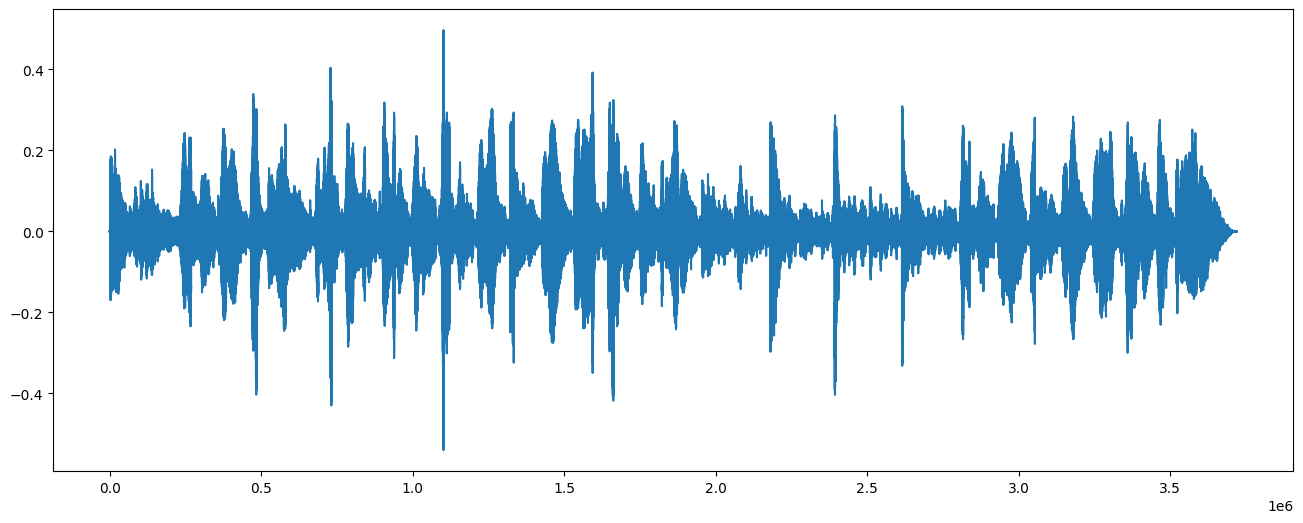

In [13]:
# not using stft for now
import librosa

x, sr = librosa.load('../data/song_01.wav', sr=22080)

plt.figure(figsize=(16,6))
plt.plot(x)

In [14]:
sample_size = sr * 2
x = torch.tensor(x)
cutoff = x.shape[0] - (x.shape[0] % sample_size)
xs = x[:cutoff].view(-1, sample_size)
xs = xs[:,None,...]
xs.shape

torch.Size([84, 1, 44160])

In [15]:
out = model(xs[:3])[0]
out.shape

torch.Size([3, 1, 44160])

torch.Size([44160])

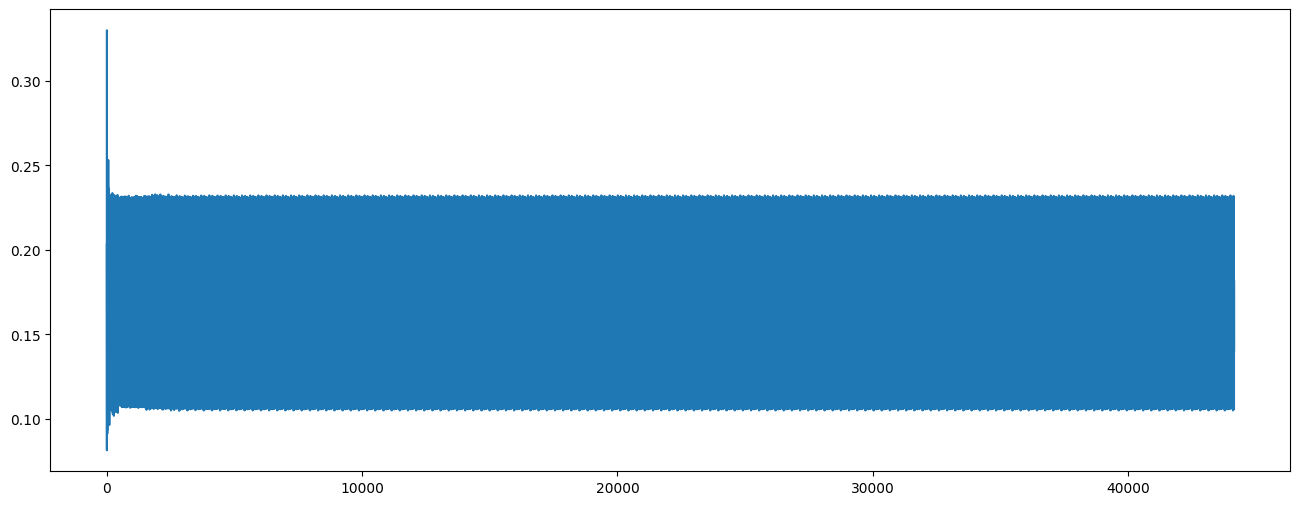

In [16]:
plt.figure(figsize=(16,6))
untrained_sample = out[1].squeeze().detach()
plt.plot(untrained_sample)
untrained_sample.shape

In [17]:
from IPython.display import Audio

Audio(xs[61].squeeze().tolist(), rate=sr)

In [103]:
device = "cuda:1"
BASE = (1, 32, 512, 1024, 8)
MED = (1, 16, 256, 512, 4)
SMALL = (1, 8, 128, 256, 4)
model = SoundStream(*SMALL)
model.to(device)
model.train()

lr = 3e-4
optimizer = torch.optim.Adam(model.generator_parameters(), lr=lr)
discr_optimizers = [torch.optim.Adam(discr.parameters(), lr=lr) for discr in model.discriminators]
steps = 100
pbar = tqdm(total=steps)
losses = []
BATCH_SIZE = 32
loss_dicts = []
discriminator_loss_log = defaultdict(list)


for i in range(steps):
    pbar.update(1)
    batch_ix = torch.randint(0, xs.shape[0], (BATCH_SIZE,))
    inputs = xs[batch_ix].to(device)
    
    # generator update
    out, embs, codes, loss, loss_dict = model(inputs, breakout_losses=True)
    
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())
    loss_dicts.append(loss_dict)
    pbar.set_description(desc=f"gen loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")
    
    # discriminator update
    disc_batch_ix = torch.randint(0, xs.shape[0], (BATCH_SIZE,))
    disc_inputs = xs[disc_batch_ix].to(device)
    discriminator_losses = model(disc_inputs, return_discriminator_loss=True)
    
    for key, dloss in discriminator_losses:
        dloss.backward(retain_graph=True)
        discriminator_loss_log[key].append(dloss.item())
        
    for d_optim in discr_optimizers:
        d_optim.zero_grad()
        d_optim.step()
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

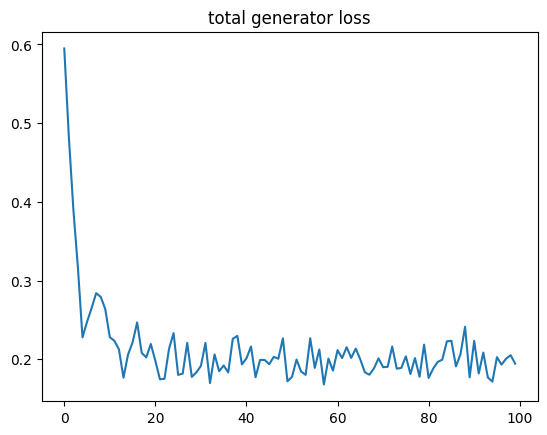

In [104]:
plt.plot(losses)
plt.title("total generator loss");

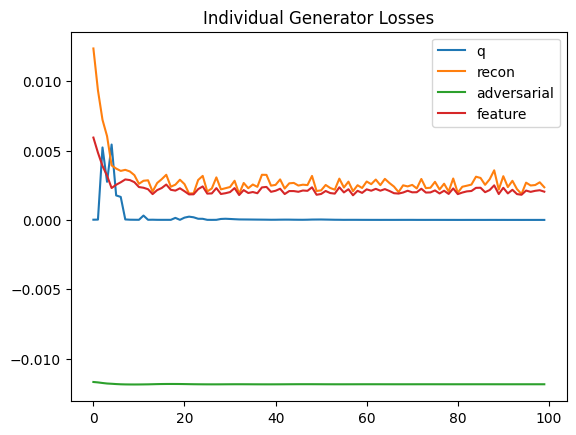

In [105]:
#plt.plot(losses)
#legend = ['total']
legend = []
if len(loss_dicts):
    for key in loss_dicts[0].keys():
        key_plot = [x[key].item() for x in loss_dicts]
        plt.plot(key_plot)
        legend.append(key)
        
plt.legend(legend)
plt.title("Individual Generator Losses");     

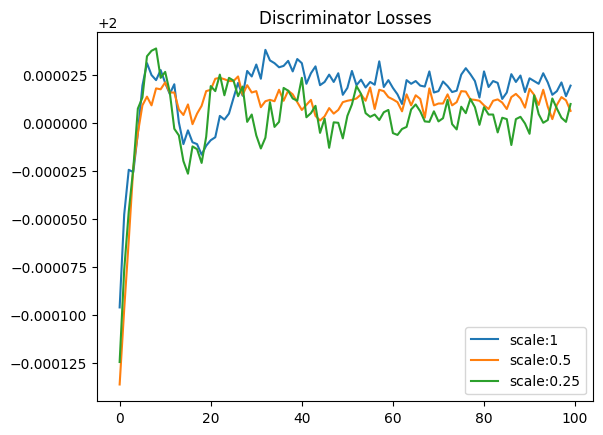

In [106]:
legend = []
for key in discriminator_loss_log:
    plt.plot(discriminator_loss_log[key])
    legend.append(key)
plt.legend(legend);
plt.title("Discriminator Losses");

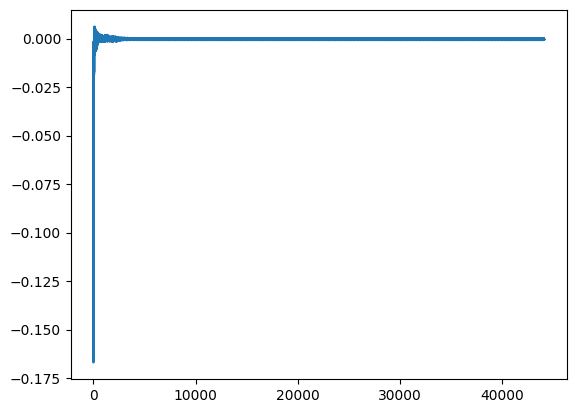

In [107]:
sample_ix = 32
out, embs, codes, loss =  model(xs[sample_ix][None,...].to(device))
#
plt.plot(out.squeeze().cpu().detach())

In [108]:
Audio(out.squeeze().tolist(), rate=sr)

In [ ]:
Audio(xs[sample_ix].squeeze().tolist(), rate=sr)

In [ ]:
out.squeeze()[:30], xs[sample_ix].squeeze()[:30]